In [1]:
%pylab nbagg

from astropy.table import Table
from astroML.stats import fit_bivariate_normal
from matplotlib.patches import Ellipse

Populating the interactive namespace from numpy and matplotlib


# Data

In [2]:
ngc = 3201
t = Table.read('Semi-major-folder/NGC{:}_All_star_cleaned_Gaia.csv'.format(ngc))
cluster = 'NGC {:}'.format(ngc)
print('{:} stars in {:} catalogue'.format(len(t),cluster))

2729 stars in NGC 3201 catalogue


# Fitting

<IPython.core.display.Javascript object>


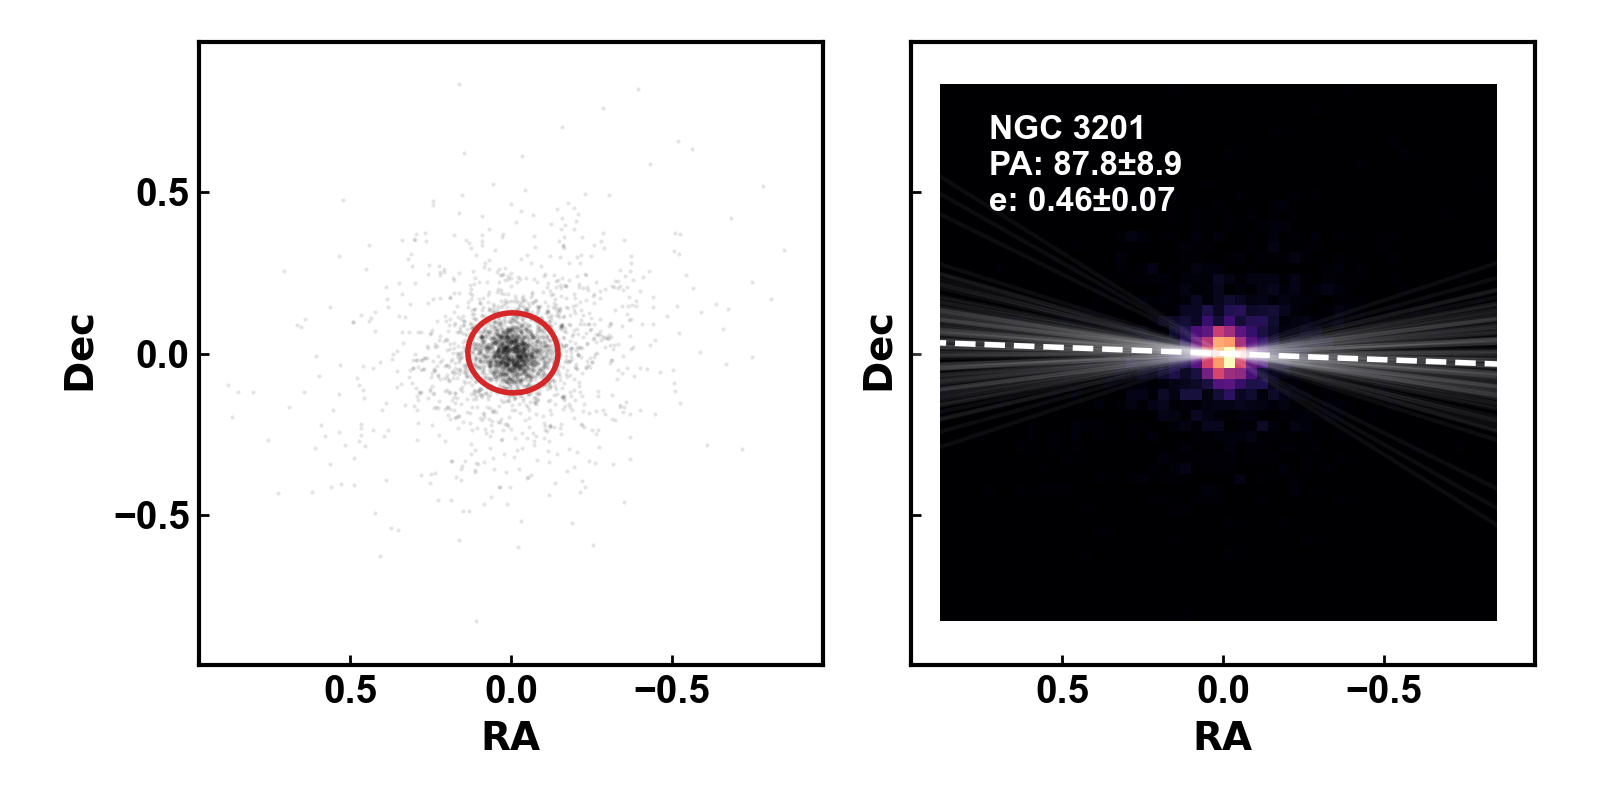

PA: 87.8±8.9
e: 0.46±0.07


In [3]:
#data
X = np.vstack([t['ra_c'],t['dec_c']]).T

#fraction of data points to bootstrap
fraction = 1.
# no. of bootstrap realizations
n = 100

limit = np.abs(X).max()*1.1
_x = np.linspace(-limit,limit,3)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(8, 4))

ax[0].plot(t['ra_c'],t['dec_c'],'.',ms=1,alpha=.1,color='k',zorder=0)
ax[0].set_ylabel(r'$\rm Dec$')
ax[0].set_xlabel(r'$\rm RA$')

ra_bins = 51
dec_bins = 51

H, ra_bins, dec_bins = np.histogram2d(t['ra_c'],t['dec_c'],
                                          (ra_bins, dec_bins))

ax[1].imshow(H.T,
              origin='lower', interpolation='nearest', aspect='auto',
              extent=[ra_bins[0], ra_bins[-1],
                      dec_bins[0], dec_bins[-1]],
              cmap=plt.cm.magma)
ax[1].xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.5))

fig.tight_layout()
for _ax in ax:
    _ax.set_aspect(1)
    _ax.set_ylabel(r'$\rm Dec$')
    _ax.set_xlabel(r'$\rm RA$')
    _ax.set_xlim( limit, -limit)
    _ax.set_ylim(-limit, limit)
    
_mu_nr = []
_mu_r = []
_sigma1_nr = [] 
_sigma1_r = []
_sigma2_nr = []
_sigma2_r = []
_alpha_nr = []
_alpha_r = []

for i in range(n):
    #bootstrap
    N = int(np.floor(X.shape[0]*fraction))
    boot_mask = np.random.choice(X.shape[0], N)
    
    x, y = X[boot_mask].T

    # compute the non-robust statistics
#     (mu_nr, sigma1_nr, sigma2_nr, alpha_nr) = fit_bivariate_normal(x, y, robust=False)

#     # compute the robust statistics
    (mu_nr, sigma1_nr,sigma2_nr, alpha_nr) = fit_bivariate_normal(x, y, robust=True)
    
    _mu_nr.append(mu_nr)
    _sigma1_nr.append(sigma1_nr)
    _sigma2_nr.append(sigma2_nr)
    
    PA_flip = 90
    if PA_flip==90:
        #if PA too close to ±90 keep this alpha
        #otherwise continue with the rest of 
        #the loop
        _alpha_nr.append(alpha_nr) 
    else:
        # I'm setting -90<PA<90 
        _pa = (np.pi*0.5-alpha_nr)
        if _pa > np.pi/2:
            _pa -= np.pi
            _alpha_nr.append((np.pi*0.5)-_pa)
        else:
            _alpha_nr.append(alpha_nr)
    
    ax[1].plot(_x,np.tan(alpha_nr)*_x,color='white',alpha=0.05)
    
print('PA: {:.1f}±{:.1f}'.format(90-(np.median(_alpha_nr)* 180. / np.pi),
                                                   (np.std(_alpha_nr)* 180. / np.pi)))
ax[1].plot(_x,np.tan(np.median(_alpha_nr))*_x,color='white',alpha=1,lw=2,ls='--')

e = (1-(np.median(_sigma2_nr)**2/np.median(_sigma1_nr)**2))**.5
e_err = np.std((1-np.r_[_sigma2_nr]**2/np.r_[_sigma1_nr]**2)**.5)

txt = '{:}\nPA: {:.1f}±{:.1f}\ne: {:.2f}±{:.2f}'.format(cluster,90-(np.median(_alpha_nr)* 180. / np.pi),
                                      (np.std(_alpha_nr)* 180. / np.pi),e,e_err)
print('e: {:.2f}±{:.2f}'.format(e,e_err))
ax[1].text(0.75*limit, 0.6*limit, txt,ha='left', va='center', fontsize = 12,color='white')
# ax[1].text(0.65*limit, -0.65*limit, txt,ha='left', va='center', fontsize = 12,color='white')

# ax[0].text(-0.85*limit, 0.75*limit, '{:}'.format(cluster),ha='right', va='center', fontsize = 12,color='k',weight='bold')

Nsig=3
# Non-robust fit
E = Ellipse(np.median(_mu_nr,axis=0), np.median(_sigma1_nr) * Nsig, np.median(_sigma2_nr) * Nsig,(np.median(_alpha_nr) * 180. / np.pi),ec='tab:red', fc='none', linestyle='-',lw=2)
ax[0].add_patch(E)

In [306]:
plt.savefig('robust_fits/{:}_PA.pdf'.format(cluster).replace(" ", ""),bbox_inches='tight')